In [107]:
import pandas as pd
import xml.etree.ElementTree
import unicodedata
import urllib2

In [137]:
def get_proposicao(tipo, numero, ano):
    url = 'http://www.camara.leg.br/SitCamaraWS/Proposicoes.asmx/ObterVotacaoProposicao?tipo=%s&numero=%s&ano=%s' % (tipo, numero, ano)
    file = urllib2.urlopen(url)
    return file

#root = xml.etree.ElementTree.parse('votacao.xml').getroot()
xml_file = get_proposicao('PL', 1992, 2007)
xml_root = xml.etree.ElementTree.parse(xml_file).getroot()

In [189]:
class Votante:
    
    def __init__(self, id):
        self.id = id
        self.votos = {}
        
    def add_voto(self, voto, votacao):
        
        if self.votos is None:
            self.votos = {}
        
        if isinstance(voto, unicode):
            voto = unicodedata.normalize('NFKD', voto).encode('ascii','ignore')
        
        self.votos[votacao.id] = voto
    
    def __repr__(self):
        return '%s - %s' % (self.id, self.votos)
    
class Deputado(Votante):
    
    def __repr__(self):
        return "%s - %s - %s" % (self.nome.encode('utf-8'), self.partido, self.votos)
    
class Bancada(Votante):
    pass


class Votacao:
    
    def __init__(self, id):
        self.id = id
        self.objeto = None
        self.data = None
        self.hora = None
        self.resumo = None
        
    def __repr__(self):
        return '%s - %s' % (self.id, self.resumo.encode('utf-8'))

class Proposicao:
    
    def __init__(self, xml_root=None):
        
        self.votantes = {}
        self.votacoes = {}
        
        if xml:
            self.parse_xml(xml_root)
            
        else:
            self.votantes = {}
            self.sigla = None
            self.numero = None
            self.ano = None
    
    def __get_votante(self, id, tipo):
    
        if id in self.votantes:
            return self.votantes[id]

        elif tipo == 'Deputado':
            votante = Deputado(id)

        elif tipo == 'bancada':
            votante = Bancada(id)

        else:
            votante = Votante(id)

        self.votantes[id] = votante
        return votante
    
    def __get_votacao(self, id):
        
        id = unicodedata.normalize('NFKD', unicode(id)).encode('ascii','ignore')
        
        if id in self.votacoes:
            return self.votacoes[id]
        else:
            votacao = Votacao(id)
        self.votacoes[id] = votacao
        return votacao
    
    def parse_xml(self, xml_root):
        
        for proposicao in xml_root:        
            #print(prop.tag, prop.attrib)
            
            if proposicao.tag == 'Sigla':
                self.sigla = proposicao.text
                
            if proposicao.tag == 'Numero':
                self.numero = proposicao.text
                
            if proposicao.tag == 'Ano':
                self.ano = proposicao.text
                
            for votacao in proposicao:
                #print(votacao.tag, votacao.text)
                _votacao = self.__get_votacao(votacao.attrib['ObjVotacao'])
                _votacao.cod_sessao = votacao.attrib['codSessao']
                _votacao.objeto = votacao.attrib['ObjVotacao']
                _votacao.data = votacao.attrib['Data']
                _votacao.hora = votacao.attrib['Hora']
                _votacao.resumo = votacao.attrib['Resumo']
                
                for tipos_votacao in votacao:
                    #print(tipos_votacao.tag, tipos_votacao.text)

                    for voto in tipos_votacao:

                        if voto.tag == 'Deputado':
                            votante = self.__get_votante(voto.attrib['ideCadastro'], voto.tag)
                            votante.nome = voto.attrib['Nome'].strip()
                            votante.partido = voto.attrib['Partido'].strip()
                            votante.uf = voto.attrib['UF'].strip()
                            votante.add_voto(voto.attrib['Voto'].strip(), _votacao)
                        else:
                            votante = self.__get_votante(voto.attrib['Sigla'], voto.tag)
                            votante.add_voto(voto.attrib['orientacao'].strip(), _votacao)
                            
    def __repr__(self):
        return '%s - %s/%s (%d votações; %d votantes)' % (self.sigla, self.numero, self.ano, len(self.votacoes), len(self.votantes))

proposicao = Proposicao(xml_root)
proposicao

PL - 1992/2007 (4 votações; 497 votantes)

In [184]:
proposicao.votantes

{'109152': Bernardo Santana de Vasconcellos - PR - {'SUBEMENDA SUBSTITUTIVA GLOBAL DE PLENARIO': 'Sim'},
 '116663': Alfredo Sirkis - PV - {'DVS - PSDB - ART. 4o DO PROJETO ORIGINAL (E SEUS CORRESPONDENTES.)...': 'Nao', 'DVS - PSDB - EMENDA 43': 'Nao'},
 '118384': Dr. Carlos Alberto - PMN - {'DVS - DEM - EMENDA 26': 'Sim', 'SUBEMENDA SUBSTITUTIVA GLOBAL DE PLENARIO': 'Nao', 'DVS - PSDB - ART. 4o DO PROJETO ORIGINAL (E SEUS CORRESPONDENTES.)...': 'Nao', 'DVS - PSDB - EMENDA 43': 'Nao'},
 '121759': Marllos Sampaio - PMDB - {'DVS - DEM - EMENDA 26': 'Nao', 'SUBEMENDA SUBSTITUTIVA GLOBAL DE PLENARIO': 'Sim', 'DVS - PSDB - ART. 4o DO PROJETO ORIGINAL (E SEUS CORRESPONDENTES.)...': 'Nao', 'DVS - PSDB - EMENDA 43': 'Nao'},
 '122195': Leonardo Gadelha - PSC - {'DVS - DEM - EMENDA 26': 'Nao', 'SUBEMENDA SUBSTITUTIVA GLOBAL DE PLENARIO': 'Sim', 'DVS - PSDB - ART. 4o DO PROJETO ORIGINAL (E SEUS CORRESPONDENTES.)...': 'Nao', 'DVS - PSDB - EMENDA 43': 'Nao'},
 '123756': Antônia Lúcia - PSC - {'SUBEM

In [181]:
proposicao.votacoes

{'DVS - DEM - EMENDA 26': DVS - DEM - EMENDA 26 - Rejeitada a Emenda nº 26. Sim: 11; não: 275; abstenção:02; total: 388.,
 'DVS - PSDB - ART. 4o DO PROJETO ORIGINAL (E SEUS CORRESPONDENTES.)...': DVS - PSDB - ART. 4o DO PROJETO ORIGINAL (E SEUS CORRESPONDENTES.)... - Rejeitado o art. 4º do Projeto original e mantido o texto da Subemenda Substitutiva Global. Sim: 41; não: 273; abstenção: 11; total: 325.,
 'DVS - PSDB - EMENDA 43': DVS - PSDB - EMENDA 43 - Rejeitada a Emenda nº 43, objeto do Destaque para votação em separado da bancada do PSDB. Sim: 55; não: 292; abstenção: 04; total: 351.,
 'SUBEMENDA SUBSTITUTIVA GLOBAL DE PLENARIO': SUBEMENDA SUBSTITUTIVA GLOBAL DE PLENARIO - Aprovada a Subemenda Substitutiva Global oferecida pelo Relator da Comissão de Seguridade Social e Família, ressalvados os destaques. Sim: 318; não: 134; abstenção: 02; total: 454.}

In [204]:
df = pd.DataFrame()

for i, votante in proposicao.votantes.iteritems():
    
    if isinstance(votante, Deputado):
        #print(i, item)
        row = {'nome': votante.nome, 'partido': votante.partido, 'uf': votante.uf}
        
        for j, votacao in proposicao.votacoes.iteritems():
            row[votacao.id] = votante.votos.get(votacao.id)
            
        df = df.append(row, ignore_index=True)
        
df = df.iloc[1:]
df

,DVS - DEM - EMENDA 26,DVS - PSDB - ART. 4o DO PROJETO ORIGINAL (E SEUS CORRESPONDENTES.)...,DVS - PSDB - EMENDA 43,SUBEMENDA SUBSTITUTIVA GLOBAL DE PLENARIO,nome,partido,uf
1,Sim,Nao,Sim,Nao,Fábio Souto,DEM,BA
2,Nao,Nao,None,Sim,Fátima Pelaes,PMDB,AP
3,Sim,Sim,Nao,Nao,Rubens Bueno,PPS,PR
4,None,None,Nao,None,Jaime Martins,PR,MG
5,Nao,Nao,Nao,Sim,Marllos Sampaio,PMDB,PI
6,Sim,Sim,None,Sim,Marcus Pestana,PSDB,MG
7,Nao,Nao,Nao,Sim,Francisco Araújo,PSD,RR
8,Nao,None,None,Sim,Assis Carvalho,PT,PI
9,Nao,Nao,Nao,Sim,Perpétua Almeida,PCdoB,AC
10,Sim,Nao,Nao,Nao,Henrique Afonso,PV,AC


In [208]:
def get_values(x):
    if x == 'Sim': 
        return 1 
    else: 
        return 0

df[df.columns[:4]] = df[df.columns[:4]].applymap(lambda x: get_values(x))
df

,DVS - DEM - EMENDA 26,DVS - PSDB - ART. 4o DO PROJETO ORIGINAL (E SEUS CORRESPONDENTES.)...,DVS - PSDB - EMENDA 43,SUBEMENDA SUBSTITUTIVA GLOBAL DE PLENARIO,nome,partido,uf
1,1,0,1,0,Fábio Souto,DEM,BA
2,0,0,0,1,Fátima Pelaes,PMDB,AP
3,1,1,0,0,Rubens Bueno,PPS,PR
4,0,0,0,0,Jaime Martins,PR,MG
5,0,0,0,1,Marllos Sampaio,PMDB,PI
6,1,1,0,1,Marcus Pestana,PSDB,MG
7,0,0,0,1,Francisco Araújo,PSD,RR
8,0,0,0,1,Assis Carvalho,PT,PI
9,0,0,0,1,Perpétua Almeida,PCdoB,AC
10,1,0,0,0,Henrique Afonso,PV,AC


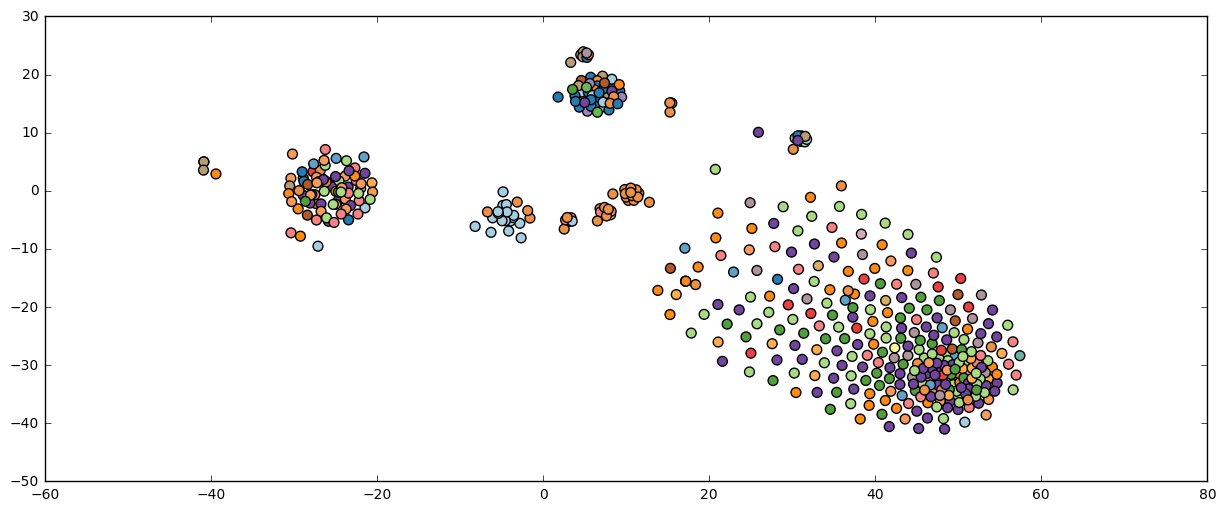

In [213]:
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
le.fit(df['partido'])

X_tsne = TSNE(learning_rate=1000, random_state=17).fit_transform(df[df.columns[:4]])

plt.figure(figsize=(15, 6))
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=le.transform(df['partido']), s=50, cmap=plt.cm.Paired)